# Code adapted and modified from original source: https://github.com/IPCC-WG1/Chapter-7/blob/main/notebooks/310_chapter7_fig7.22.ipynb

# Plot fig 7.22

Theme Song: Into The Waves<br>
Artist: Alcest<br>
Album: Shelter<br>
Released: 2014

Plotting Figure ~~7.24~~7.21. now 7.22 for Chapter 7 AR6, Piers Forster 23 Febuary 2021
Bug fixed 9 March 2021

In [1]:
import fair
fair.__version__

'1.6.2'

In [2]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
from matplotlib import gridspec, rc
from matplotlib.lines import Line2D
import matplotlib.patches as mp
from netCDF4 import Dataset
import warnings
from matplotlib.ticker import AutoMinorLocator
from fair.constants import molwt
from scipy.interpolate import interp1d

In [3]:
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 9
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 150

In [4]:
# Replace Piers' SCEN files with the precise emissions going in to AR6
# from notebook 150

ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
years = np.arange(1750,2141)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2140
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

emissions = {}

scens = ['ssp126', 'ssp245', 'ssp460', 'ssp585']
for scen in scens:
    emissions[scen] = np.ones((391, 40)) * np.nan
    emissions[scen][:,0] = years

    years_future = [2015] + list(range(2020,2141,10))
    for i, specie in enumerate(species):
        emissions[scen][:first_row,i+1] = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2140'].dropna(axis=1))
        emissions[scen][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

In [5]:
emissions_noCH4 = {}
for scen in scens:
    emissions_noCH4[scen] = np.copy(emissions[scen])
    emissions_noCH4[scen][:,3] = 0

In [6]:
#AR6 impulse numbers Appendix 7.A.2: Zeb Nicholls 21.02.2021 after F2x revision to 3.93
q = np.array([0.443767729, 0.31959105])
d = np.array([3.424102092, 285.0034778])
e= 1.027855509 # not used

In [7]:
# add in natural emissions and natural forcing
ch4_n2o_df = pd.read_csv('../data_output/fair_wg3_natural_ch4_n2o.csv')
ch4_n2o = ch4_n2o_df.values[:391,1:]

In [8]:
#yr=np.arange(1750, 2101)
C26, F26, T26 = fair.forward.fair_scm(
    emissions=emissions['ssp126'],
    q=q,
    d=d,
    tcrecs = np.array([1.8, 3.0]),
    F2x=3.93,
    natural=ch4_n2o,
    F_solar=0,
    F_volcanic=0,
    ghg_forcing='Meinshausen',
    scale_F2x=False
)
C26n, F26n, T26n = fair.forward.fair_scm(
    emissions=emissions_noCH4['ssp126'],
    q=q,
    d=d,
    tcrecs = np.array([1.8, 3.0]),
    F2x=3.93,
    natural=ch4_n2o,
    F_solar=0,
    F_volcanic=0,
    ghg_forcing='Meinshausen',
    scale_F2x=False
)

C60, F60, T60 = fair.forward.fair_scm(
    emissions=emissions['ssp460'],
    q=q,
    d=d,
    tcrecs = np.array([1.8, 3.0]),
    F2x=3.93,
    natural=ch4_n2o,
    F_solar=0,
    F_volcanic=0,
    ghg_forcing='Meinshausen',
    scale_F2x=False
)
C60n, F60n, T60n = fair.forward.fair_scm(
    emissions=emissions_noCH4['ssp460'],
    q=q,
    d=d,
    tcrecs = np.array([1.8, 3.0]),
    F2x=3.93,
    natural=ch4_n2o,
    F_solar=0,
    F_volcanic=0,
    ghg_forcing='Meinshausen',
    scale_F2x=False
)

T26_ch4=T26-T26n

T60_ch4=T60-T60n

In [9]:
# 221 84 46
# 33 52 219
# 53 165 197
# 170 24 24
# 8 46 114
# 236 156 46
# 50 127 81
# 128 54 168



colors = {
    'CGTP': '#dd542e',
    'GWP100': '#2134db',
    'GTP100': '#aa1818',
    'GWP20': '#35a5c5',
    'GWP*': '#327f51',
    'GSAT': '#000000'
}

In [10]:
#CELLS TO SAVE IN SHARABLE CODE
#### function to calc GWP* for a gas
#### eventually, put this in its own file and import it to tidy things up here

def convert_gwpstar(emis1,emis0,gwp100,verbose=False):
    #emis1 is the emission list you wish to convert 
    #emis0 is the emission list for 20 years ago
    #gwp100 is the gwp value to use. 
    
    if verbose == True:
        print ('convert ',emis1, 'to co2e*')
    if verbose == True:
        print ('ch4gwp100 used is ',gwp100, 'and Delta t is ',delt)
        print ((np.subtract(emis1,emis0) ) * gwp100 * 100. / float(delt) )
    return (np.subtract(emis1,emis0) )* gwp100 * 100. / float(delt)

In [11]:
delt=20
b=np.zeros(delt)
e60long=np.append(b,emissions['ssp460'][:,3])
e26long=np.append(b,emissions['ssp126'][:,3])
yrlong=np.append(np.arange(delt)+1750-delt,years)

In [12]:
gwp100ch4=28.87

e_60=e60long[delt:]
e_60_0=e60long[:-delt]

flow60=convert_gwpstar(e_60,e_60_0,gwp100ch4,verbose=False)*0.001 #units gtCO2

e_26=e26long[delt:]
e_26_0=e26long[:-delt]
flow26=convert_gwpstar(e_26,e_26_0,gwp100ch4,verbose=False)*0.001

#cain et al: 0.75 and 0.25
#smith et al: 0.75*1.13 and 0.25*1.13
b0=0.75*1.13
a0=0.25*1.13

stock26=e26long[:]*gwp100ch4*0.001
stock60=e60long[:]*gwp100ch4*0.001

st=20
en=391
cue_26=np.cumsum(a0*stock26[st:en]+b0*flow26[st-delt:en-delt])
cue_60=np.cumsum(a0*stock60[st:en]+b0*flow60[st-delt:en-delt])


yr_gwp=yrlong[st:en]

In [13]:
e60long.shape

(411,)

In [14]:
#numbers match fossil fuel CH4 in AR6 table 7.15
TCRE = 1.65 # per Tt C
cumCO2scale = 3664/TCRE  #conversion for GtCO2

#T60_GWP100=gwp100ch4 * np.cumsum(emissions['ssp460'][:,3]) *1.65/(3.664 *1.0E6)
#T60_GWP20=84* np.cumsum(emissions['ssp460'][:,3])*1.65/(3.664 *1.0E6)

############################################################
cum_years = 40  # Number of years for cumulative sum
gwp_starting_index = 1750-1750
emissions_array = emissions['ssp460'][:, 3]

T60_GWP100 = np.zeros(len(emissions_array)-gwp_starting_index)
T60_GWP20 = np.zeros(len(emissions_array)-gwp_starting_index)

for i in range(gwp_starting_index,len(emissions_array)):
    if i < cum_years:
        T60_GWP100[i-gwp_starting_index] = gwp100ch4 * np.sum(emissions_array[:i + 1]) * 1.65 / (3.664 * 1.0E6)
        T60_GWP20[i-gwp_starting_index] = 84 * np.sum(emissions_array[:i + 1]) * 1.65 / (3.664 * 1.0E6)
    else:
        T60_GWP100[i-gwp_starting_index] = gwp100ch4 * np.sum(emissions_array[i - cum_years + 1:i + 1]) * 1.65 / (3.664 * 1.0E6)
        T60_GWP20[i-gwp_starting_index] = 84 * np.sum(emissions_array[i - cum_years + 1:i + 1]) * 1.65 / (3.664 * 1.0E6)
############################################################

        
T60_CGTP=3428 * emissions['ssp460'][:,3]*1.65/(3.664 *1.0E6)
T60_GTP100=7.3* np.cumsum(emissions['ssp460'][:,3])*1.65/(3.664 *1.0E6)
T60_GWPstar=cue_60*1.65/(3.664 *1.0E3)

# T26_GWP100=gwp100ch4 * np.cumsum(emissions['ssp126'][:,3])*1.65/(3.664 *1.0E6)
# T26_GWP20=84* np.cumsum(emissions['ssp126'][:,3])*1.65/(3.664 *1.0E6)

############################################################

emissions_array = emissions['ssp126'][:, 3]

T26_GWP100 = np.zeros(len(emissions_array)-gwp_starting_index)
T26_GWP20 = np.zeros(len(emissions_array)-gwp_starting_index)

for i in range(gwp_starting_index,len(emissions_array)):
    if i < cum_years:
        T26_GWP100[i-gwp_starting_index] = gwp100ch4 * np.sum(emissions_array[:i + 1]) * 1.65 / (3.664 * 1.0E6)
        T26_GWP20[i-gwp_starting_index] = 84 * np.sum(emissions_array[:i + 1]) * 1.65 / (3.664 * 1.0E6)
    else:
        T26_GWP100[i-gwp_starting_index] = gwp100ch4 * np.sum(emissions_array[i - cum_years + 1:i + 1]) * 1.65 / (3.664 * 1.0E6)
        T26_GWP20[i-gwp_starting_index] = 84 * np.sum(emissions_array[i - cum_years + 1:i + 1]) * 1.65 / (3.664 * 1.0E6)

years_gwp=years[gwp_starting_index:]
        
############################################################        

        
T26_CGTP=3428 * emissions['ssp126'][:,3]*1.65/(3.664 *1.0E6)
T26_GTP100=7.3* np.cumsum(emissions['ssp126'][:,3])*1.65/(3.664 *1.0E6)
T26_GWPstar=cue_26*1.65/(3.664 *1.0E3)

In [15]:
T60_GWP100.shape

(391,)

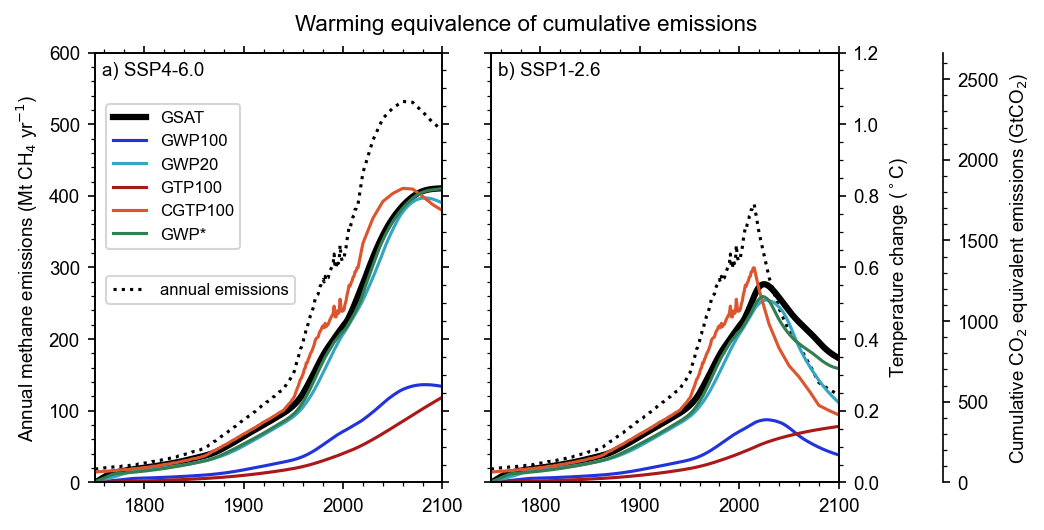

In [16]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, ax = pl.subplots(1, 2, figsize=(18/2.54, 9/2.54))
ax[0].plot(yrlong,e60long,label='annual emissions',color=colors['GSAT'],linestyle=':')
ax[0].set_ylabel('Annual methane emissions (Mt CH$_{4}$ yr$^{-1}$)')
ax[1].plot(years,abs(emissions['ssp126'][:,3]),label='annual emissions',color=colors['GSAT'],linestyle=':')
ax[1].set_yticklabels([])
#ax[1].set_ylabel('Annual methane emissions (Mt CH$_{4}$)')
ax0_1 = ax[0].twinx()
ax1_1 = ax[1].twinx()
ax0_1.plot(years,T60_ch4,color=colors['GSAT'],label='GSAT',linewidth=3)
ax0_1.plot(years_gwp,T60_GWP100,color=colors['GWP100'],label='GWP100')
ax0_1.plot(years_gwp,T60_GWP20,color=colors['GWP20'],label='GWP20')
ax0_1.plot(years,T60_GTP100,color=colors['GTP100'],label='GTP100')
ax0_1.plot(years,T60_CGTP,color=colors['CGTP'],label='CGTP100')
ax0_1.plot(yr_gwp,T60_GWPstar,color=colors['GWP*'],label='GWP*')

ax1_1.plot(years,T26_ch4,color=colors['GSAT'],label='GSAT',linewidth=3)
ax1_1.plot(years_gwp,T26_GWP100,color=colors['GWP100'],label='GWP100')
ax1_1.plot(years_gwp,T26_GWP20,color=colors['GWP20'],label='GWP20')
ax1_1.plot(years,T26_GTP100,color=colors['GTP100'],label='GTP100')
ax1_1.plot(years,T26_CGTP,color=colors['CGTP'],label='CGTP100')
ax1_1.plot(yr_gwp,T26_GWPstar,color=colors['GWP*'],label='GWP*')

#ax0_1.set_ylabel('Temperature change ($^\circ$C)')
ax1_1.set_ylabel('Temperature change ($^\circ$C)')
 

ax[0].legend(loc='upper left',bbox_to_anchor=(0.01, 0.5),fontsize=8)
ax0_1.legend(loc='upper left',bbox_to_anchor=(0.01, 0.9),fontsize=8)


fig.suptitle('Warming equivalence of cumulative emissions')

ax[0].text(0.02, 0.98, 'a) SSP4-6.0',verticalalignment='top', horizontalalignment='left',transform=ax[0].transAxes)
ax[1].text(0.02, 0.98, 'b) SSP1-2.6',verticalalignment='top', horizontalalignment='left',transform=ax[1].transAxes)
#ax[1].set_ylabel('Total radiative forcing (W.m$^{-2}$)')
ax[0].set_xlim(1750,2100)
ax[1].set_xlim(1750,2100)
ax[0].set_ylim(0,600)
ax[1].set_ylim(0,600)
ax0_1.set_ylim(0,1.2)
ax0_1.set_yticklabels([])
ax1_1.set_ylim(0,1.2)


#ax0_2 = ax[0].twinx()
ax1_2 = ax[1].twinx()

#ax0_2.spines["right"].set_position(("axes", 1.25))
#ax0_2.set_ylim(0,cumCO2scale)
#ax0_2.set_ylabel('Cumulative CO$_{2}$ equivalent emissions (GtCO$_{2}$)')
ax1_2.spines["right"].set_position(("axes", 1.3))
ax1_2.set_ylim(0,cumCO2scale * 1.2)   # whatever y-lim for temperature is
ax1_2.set_ylabel('Cumulative CO$_{2}$ equivalent emissions (GtCO$_{2}$)')

#make_patch_spines_invisible(ax0_2)
#ax0_2.spines["right"].set_visible(True)
ax1_2.spines["right"].set_visible(True)

fig.tight_layout(rect=[0,0,1,0.96])
fig.savefig("../figures/fig7.22.pdf")
fig.savefig("../figures/fig7.22.png", dpi=300)